# **Vehicle Detection for Autonomous Cars** 
***

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.

### Import Packages

In [49]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Test Vehicle Detection in Images

Built my pipeline to work on the images in the directory "test_images"

In [50]:
import os

# print test images file name
test_images_names = os.listdir("test_images/")
print(test_images_names)

['feature-extraction', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


### Read in the Test Image
I'll test each step of my pipeline on the following test image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


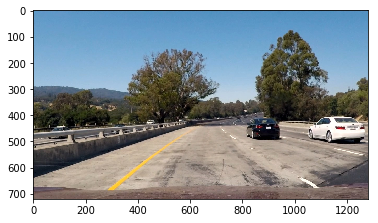

In [51]:
#reading in a test image
test_image = mpimg.imread('test_images/test1.jpg')

# printing out some stats and plotting
print('This image is:', type(test_image), 'with dimesions:', test_image.shape)
plt.imshow(test_image) 

### Draw Boxes Manually to Prototype
This function takes an image, a list of bounding boxes, and optional color tuple and line thickness as inputs and then draws boxes in that color on the output

In [52]:
def draw_boxes(img, bboxes, color=(255, 0, 0), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
            cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img 

Test drawing boxes on the test image

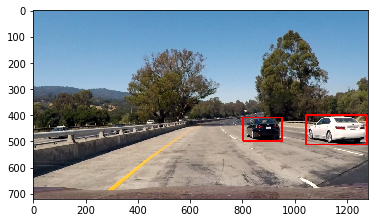

In [53]:
# manually set the coordinates of the vehicule boxes 
bboxes = [((951, 498), (803, 409)), ((1276, 512), (1043, 401))]

result = draw_boxes(test_image, bboxes)
plt.imshow(result)

## Vehicle Feature Extraction

Test Feature Extraction on this test vehicle image

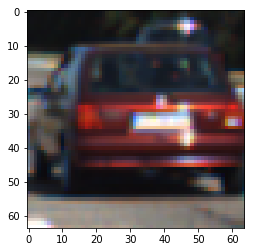

In [54]:
#reading in a vehicle test image
test_vehicle_image = mpimg.imread('test_images/feature-extraction/7.png')
plt.imshow(test_vehicle_image) 

### Histogram-of-Colors Feature Extraction

This function extracts histogram-of-colors features

In [55]:
def get_hoc_features(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

Plot Histogram of Color-Space feature extraction of Test Image

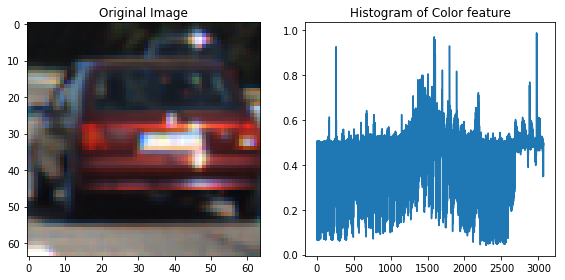

In [56]:
# Define HOC parameters
test_color_space='YCrCb'
test_size = (32,32)

test_features_color = get_hoc_features(test_vehicle_image, test_color_space, test_size)

# Plot an example of raw and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_color)
plt.title('Histogram of Color feature')
fig.tight_layout()

### Histogram-of-Gradients Feature Extraction
This function takes in a vehicle image and returns a Histogram of Gradients feature vector

In [109]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if vis == True:
        features, hog_image = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(gray, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features

Test the Histogram of Gradient feature extraction on a test image and Visualize HOG Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


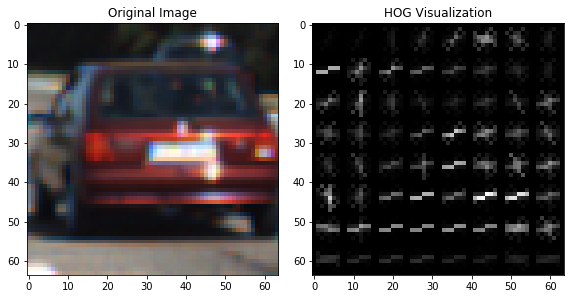

In [110]:
# Define HOG parameters
test_orient = 9
test_pix_per_cell = 8
test_cell_per_block = 2
# Call our function with vis=True to see an image output
test_features_gradient, hog_image = get_hog_features(test_vehicle_image, test_orient, 
                        test_pix_per_cell, test_cell_per_block, 
                        vis=True, feature_vec=False)

# Plot an example of raw and HOG Image
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image, cmap='gray')
plt.title('Original Image')
plt.subplot(132)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.tight_layout()

Plot Histogram of Gradient feature extraction

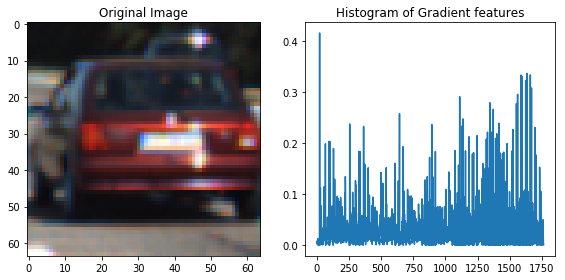

In [59]:
test_features_gradient = test_features_gradient.ravel() 

# Plot an example of raw and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_gradient)
plt.title('Histogram of Gradient features')
fig.tight_layout()

### Combine Color and Gradient Features

This function combines the extracted Histogram-of-Color and Histogram-of-Gradient features

In [111]:
from sklearn.preprocessing import StandardScaler

def combine_features(img, color_space, size, orient, pix_per_cell, cell_per_block):
    features_color = get_hoc_features(img, color_space, size)
    features_gradient = get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
    # Create a list of feature vectors
    features_combined = np.concatenate((features_color, features_gradient))

    return features_combined

Test combining Color and Gradient Features

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


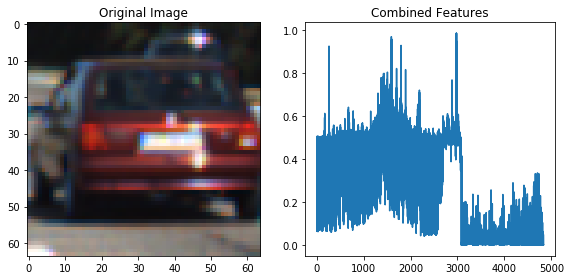

In [112]:
test_features_combined = combine_features(test_vehicle_image, test_color_space, test_size, 
                             test_orient, test_pix_per_cell, test_cell_per_block)

# Plot an example of raw and combined color and gradient features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_vehicle_image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(test_features_combined)
plt.title('Combined Features')
fig.tight_layout()

## Build a Classifier to classify Vehicles and Non-Vehicles

### Explore Vehicles and Non-Vehicles Datasets

Load Datasets

In [62]:
import glob

cars = glob.glob('datasets/cars/**/*.png', recursive=True)
notcars = glob.glob('datasets/notcars/**/*.png', recursive=True)

This function returns some characteristics of the dataset 

In [63]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Dataset has', data_info["n_cars"], 'cars and', data_info["n_notcars"], 'non-cars'
    ,'\neach of size: ',data_info["image_shape"], 'and data type:', data_info["data_type"])

Dataset has 8792 cars and 8968 non-cars 
each of size:  (64, 64, 3) and data type: float32


Plot example images of random car / not-car from the dataset

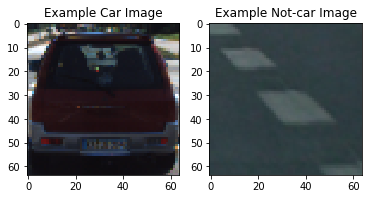

In [64]:
# Pick random index
test_car_ind = np.random.randint(0, len(cars))
test_notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
test_car_image = mpimg.imread(cars[test_car_ind])
test_notcar_image = mpimg.imread(notcars[test_notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(test_car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(test_notcar_image)
plt.title('Example Not-car Image')

### Extract Features and Labels from Dataset

This function iterates through each image in a dataset and extracts its combined HOC and HOG features

In [65]:
def extract_features_dataset(imgs, color_space, spatial_size,
                        orient, pix_per_cell, cell_per_block):
    # Create a list to append each image feature vector to
    features_dataset = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # Extract image HOC and HOG normalized features
        features_image = combine_features(image, color_space, spatial_size, orient, pix_per_cell, cell_per_block)
        features_dataset.append(features_image)
    return features_dataset

Extract features from the cars and notcars datasets

In [66]:
# Features Extraction Parameters
color_space='RGB'
spatial_size=(32, 32)
orient=12
pix_per_cell=8
cell_per_block=2

print('Extracting features from the cars and notcars datasets...')
car_features = extract_features_dataset(cars, color_space, spatial_size,
                        orient, pix_per_cell, cell_per_block)
notcar_features = extract_features_dataset(notcars, color_space, spatial_size,
                        orient, pix_per_cell, cell_per_block)
print('Successfully extracted features from the cars and notcars datasets.')

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Successfully extracted features from the cars and notcars datasets


Plot the features of a random car from the dataset

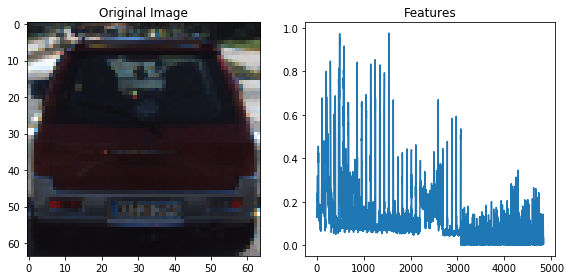

In [108]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[test_car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(car_features[test_car_ind])
plt.title('Features')
fig.tight_layout()

Plot the features of a random notcar from the dataset

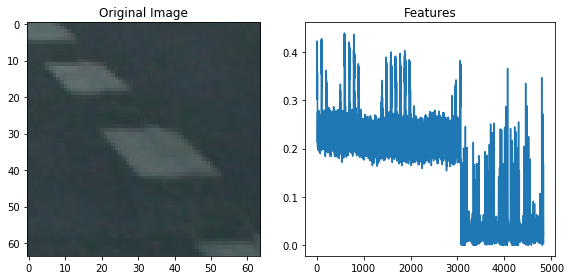

In [70]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(notcars[test_notcar_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(notcar_features[test_notcar_ind])
plt.title('Features')
fig.tight_layout()

Create the normalized features vector for the combined dataset

In [72]:
print('Creating the normalized features vector...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Successfully created the normalized features vector.')

Creating the normalized features vector...
Successfully created the normalized features vector.


Create the labels vector for the dataset (1's for cars, 0's for non-cars).

In [75]:
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

Shuffle and split the data into training and testing sets

In [27]:
from sklearn.model_selection import train_test_split

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### Support Vector Machine Classifier

Build and Train the Classifier

In [76]:
from sklearn import svm, model_selection

print('Training the classifier...')

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print('Successfully trained the classifier.')
print('\nBest parameters chosen by GridSearchCV:', clf.best_params_)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

Training the classifier...
Successfully trained the classifier.

Best parameters chosen by GridSearchCV: {'kernel': 'rbf', 'C': 10}
Test Accuracy of SVC =  0.9949


## Implement Sliding Window Search

### Get Sliding Windows
This function takes windows start/stop positions, windows size and windows overlap, and returns a list of bounding boxes for the search windows

In [79]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

Draw Search Windows on a Test Image

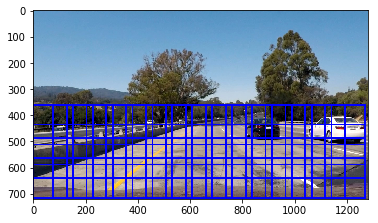

In [154]:
# Test image shape
test_image_height = test_image.shape[0]
test_image_width = test_image.shape[1]

# Parameters for slide_window() function
test_x_start_stop=[0, test_image_width]
test_y_start_stop=[int(test_image_height/2), test_image_height]
test_xy_window=(128, 128)
test_xy_overlap=(0.4, 0.4)

test_windows = slide_window(test_image, test_x_start_stop, test_y_start_stop, 
                    test_xy_window, test_xy_overlap)
                       
window_img = draw_boxes(test_image, test_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Search Sliding Windows and Detect Vehicle Windows

In [159]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
            spatial_size=(32, 32), orient=9, pix_per_cell=8, cell_per_block=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window 
        features_window = combine_features(img_window, color_space, spatial_size, orient, pix_per_cell, cell_per_block)
        #5) Scale extracted features to be fed to classifier
        features_window_scaled = scaler.transform(np.array(features_window).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(features_window_scaled)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Test Detecting Vehicle Windows in Test Image

C:\Users\Vincent\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


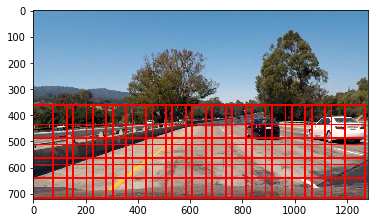

In [160]:
test_hot_windows = search_windows(test_image, test_windows, clf, X_scaler, color_space, 
                                  spatial_size, orient, pix_per_cell, cell_per_block)         

test_window_img = draw_boxes(test_image, test_hot_windows, color=(255, 0, 0), thick=6)                    

plt.imshow(test_window_img)